# Introduction
This Jupyter notebook supports the project “Toxicity in Steam Community Reviews: Patterns Across Game Characteristics and Review Types.” It demonstrates a single end-to-end example of data collection and preprocessing for one Steam game. The final section of the notebook presents the resulting graphs and visual summaries.

# 0: Install and Import the depenencies

In [1]:
# !pip install requests
# !pip install selenium
# !pip install langdetect
# !pip install detoxify
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install ipywidgets
# !pip install tqdm
# !pip install wordcloud

In [2]:
import re
import csv
import argparse
import json
import requests
import random

from typing import List, Dict, Any

import numpy as np
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.edge.options import Options as EdgeOptions
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException


from time import sleep
from datetime import datetime
from langdetect import detect
from detoxify import Detoxify

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

# 1: Data Scraping
We first define the configurations for the scraping process. Note that only a subset of game is listed here to demonstrate the process.

In [3]:
# Configuration
LANGUAGE_FILTER = 'english'
MAX_SCROLL_ATTEMPTS = 3
SCROLL_WAIT_TIME = 1.0
PAGE_LOAD_WAIT = 2.0
MAX_SCROLLS_PER_GAME = 200
DEFAULT_TARGET_POSITIVE = 500
DEFAULT_TARGET_NEGATIVE = 500
DEFAULT_OUTPUT_FILE = 'steam_reviews_all_games.csv'
STORE_URL_TEMPLATE = 'https://store.steampowered.com/app/{game_id}/'

# Default game configuration
DEFAULT_GAME_CONFIG: List[Dict[str, Any]] = [
    # FPS
    {"game_id": 1172470, "game_name": "Apex Legends", "genre": "FPS", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 730, "game_name": "Counter-Strike 2", "genre": "FPS", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2807960, "game_name": "Battlefield 6", "genre": "FPS", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # RPG
    # {"game_id": 1245620, "game_name": "ELDEN RING", "genre": "RPG", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 990080, "game_name": "Hogwarts Legacy", "genre": "RPG", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2161700, "game_name": "Persona 3 Reload", "genre": "RPG", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # Indie
    # {"game_id": 1426210, "game_name": "It Takes Two", "genre": "Indie", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 1030300, "game_name": "Hollow Knight: Silksong", "genre": "Indie", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 413150, "game_name": "Stardew Valley", "genre": "Indie", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # Strategy
    # {"game_id": 1466860, "game_name": "Age of Empires IV", "genre": "Strategy", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 289070, "game_name": "Sid Meier's Civilization VI", "genre": "Strategy", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 394360, "game_name": "Hearts of Iron IV", "genre": "Strategy", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # Simulation
    # {"game_id": 1222670, "game_name": "The Sims 4", "genre": "Simulation", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2300320, "game_name": "Farming Simulator 25", "genre": "Simulation", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 270880, "game_name": "American Truck Simulator", "genre": "Simulation", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # MOBA
    # {"game_id": 570, "game_name": "Dota 2", "genre": "MOBA", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2357570, "game_name": "Overwatch 2", "genre": "MOBA", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 1283700, "game_name": "SUPERVIVE", "genre": "MOBA", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # # Co-op / Multiplayer
    # {"game_id": 3527290, "game_name": "PEAK", "genre": "Co-op / Multiplayer", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 550, "game_name": "Left 4 Dead 2", "genre": "Co-op / Multiplayer", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 648800, "game_name": "Raft", "genre": "Co-op / Multiplayer", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2246340, "game_name": "Monster Hunter Wilds", "genre": "Co-op / Multiplayer", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
    # {"game_id": 2001120, "game_name": "Split Fiction", "genre": "Co-op / Multiplayer", "target_positive": DEFAULT_TARGET_POSITIVE, "target_negative": DEFAULT_TARGET_NEGATIVE},
]

To peform the data scraping, we first have to create a driver.

In [4]:
def create_driver():
    """Create and configure Edge WebDriver"""
    options = EdgeOptions()
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--no-sandbox')
    return webdriver.Edge(options=options)


def create_chrome_driver():
    """Create and configure Chrome WebDriver"""
    options = ChromeOptions()
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--no-sandbox')
    return webdriver.Chrome(options=options)

We also need some helper functions for scraping the content.

In [5]:
def bypass_content_warning(driver):
    """
    Some games show a content warning / age gate on the community page.
    Try to click the \"View Community Hub\" button so we can see reviews.
    """
    try:
        # Prefer the known button class if present (works for <button> and <a>)
        try:
            button = driver.find_element(
                By.CSS_SELECTOR, "button.btn_blue_steamui.btn_medium, a.btn_blue_steamui.btn_medium"
            )
        except NoSuchElementException:
            # Fallback: look for the primary button with this label
            button = driver.find_element(
                By.XPATH,
                "//*[contains(@class, 'btn_blue_steamui') and contains(., 'View Community Hub')]",
            )

        if button:
            button.click()
            sleep(PAGE_LOAD_WAIT)
            print("Bypassed content warning by clicking 'View Community Hub'.")
    except NoSuchElementException:
        # No gate on this page – nothing to do
        return
    except Exception as exc:
        print(f"Warning: Failed to bypass content warning: {exc}")


def get_review_url(game_id, review_type, language):
    """Generate Steam review URL with language filter"""
    base_url = f'https://steamcommunity.com/app/{game_id}/{review_type}/'
    params = '?browsefilter=mostrecent&filterLanguage=' + language
    return base_url + params


def fetch_game_metadata(game_id):
    """Fetch overall review summary, review count, and tags from Steam store page"""
    url = STORE_URL_TEMPLATE.format(game_id=game_id)
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
            '(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        )
    }
    metadata = {
        'overall_review_summary': '',
        'total_review_count': '',
        'store_tags': [],
    }

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        html = response.text

        summary_match = re.search(
            r'class="game_review_summary.*?>(.*?)<', html, re.IGNORECASE | re.DOTALL
        )
        if summary_match:
            metadata['overall_review_summary'] = summary_match.group(1).strip()

        count_match = re.search(
            r'responsive_reviewdesc">.*?\(([\d,]+)\)', html, re.IGNORECASE | re.DOTALL
        )
        if count_match:
            metadata['total_review_count'] = count_match.group(1).strip()

        tag_matches = re.findall(r'class="app_tag".*?>(.*?)<', html, re.IGNORECASE | re.DOTALL)
        tags = [tag.strip() for tag in tag_matches if tag.strip()]
        metadata['store_tags'] = tags[:10]  # limit to top 10 tags

    except Exception as exc:
        print(f"Warning: Could not fetch metadata for game {game_id}: {exc}")

    return metadata


def extract_helpful_votes(card):
    """Extract helpful vote count from a review card"""
    text = safe_find_element(card, './/div[contains(@class, "found_helpful")]', "")
    if not text:
        return 0
    match = re.search(r'(\d+)', text.replace(',', ''))
    return int(match.group(1)) if match else 0


def safe_find_element(card, xpath, default=""):
    """Safely find element by XPath, return default if not found"""
    try:
        element = card.find_element(By.XPATH, xpath)
        return element.text if hasattr(element, 'text') else element.get_attribute('href') or element.get_attribute('src') or default
    except (NoSuchElementException, StaleElementReferenceException):
        return default


def extract_numeric_value(text, pattern=r'(\d+\.?\d*)'):
    """Extract numeric value from text using regex"""
    match = re.search(pattern, text)
    return float(match.group(1)) if match else 0.0


def is_english_review(card):
    """Check if review is in English"""
    # Check language indicator if available
    language = safe_find_element(card, './/div[contains(@class, "language")]', "")
    if language:
        return 'english' in language.lower()
    
    # If no language indicator, assume English (since URL filters for English)
    # Additional check: look for common non-English characters
    review_content = safe_find_element(card, './/div[@class="apphub_CardTextContent"]', "")
    if review_content:
        # Check for common non-English character patterns
        non_english_patterns = [
            r'[\u4e00-\u9fff]',  # Chinese
            r'[\u3040-\u309f\u30a0-\u30ff]',  # Japanese
            r'[\u0400-\u04ff]',  # Cyrillic
            r'[\u0590-\u05ff]',  # Hebrew
            r'[\u0600-\u06ff]',  # Arabic
        ]
        for pattern in non_english_patterns:
            if re.search(pattern, review_content):
                return False
    
    return True


def extract_review_data(card):
    """Extract all data from a review card"""
    try:
        # Extract date and review content
        date_posted = safe_find_element(card, './/div[@class="apphub_CardTextContent"]/div', "")
        review_content_elem = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]')
        review_content = review_content_elem.text.replace(date_posted, '').strip()
        
        # Calculate review lengths
        review_length_chars = len(review_content.replace(' ', ''))
        review_length_words = len(review_content.split())
        
        # Extract recommendation status
        thumb_text = safe_find_element(card, './/div[@class="reviewInfo"]/div[2]', "")
        if thumb_text:
            # Check for "Not Recommended" first, then "Recommended"
            if "Not Recommended" in thumb_text:
                is_recommended = False
            elif "Recommended" in thumb_text:
                is_recommended = True
            else:
                is_recommended = None
        else:
            is_recommended = None
        
        # Extract play hours
        play_hours_text = safe_find_element(card, './/div[@class="reviewInfo"]/div[3]', "")
        play_hours = extract_numeric_value(play_hours_text)
        
        # Extract review language
        review_language = safe_find_element(card, './/div[contains(@class, "language")]', "")

        helpful_votes = extract_helpful_votes(card)
        return {
            'review_content': review_content,
            'review_length_chars': review_length_chars,
            'review_length_words': review_length_words,
            'is_recommended': is_recommended,
            'play_hours_text': play_hours_text,
            'play_hours': play_hours,
            'review_language': review_language,
            'date_posted': date_posted,
            'helpful_votes': helpful_votes,
        }
    except (NoSuchElementException, StaleElementReferenceException) as e:
        print(f"Error extracting review data: {e}")
        return None


def scroll_to_load_more(driver, last_position, max_attempts=MAX_SCROLL_ATTEMPTS):
    """Scroll page to load more reviews"""
    scroll_attempt = 0
    
    while scroll_attempt < max_attempts:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        sleep(SCROLL_WAIT_TIME)
        driver.execute_script("window.scrollBy(0, 500);")
        sleep(SCROLL_WAIT_TIME / 2)
        
        curr_position = driver.execute_script("return window.pageYOffset;")
        
        if curr_position == last_position:
            scroll_attempt += 1
            sleep(SCROLL_WAIT_TIME)
            if scroll_attempt >= max_attempts:
                return None, True  # Reached end
        else:
            return curr_position, False  # Made progress
    
    return None, True

The following function combines the helper functions and scrpae the content from Steam reviews.

In [6]:
def scrape_reviews_for_game(driver, game, review_type, target_count, language=LANGUAGE_FILTER, game_metadata=None):
    """
    Scrape reviews for a single game and sentiment until target_count or page end.
    review_type: 'positivereviews' or 'negativereviews'
    """
    game_id = game['game_id']
    game_name = game.get('game_name', str(game_id))
    genre = game.get('genre', '')
    sentiment = 'positive' if review_type == 'positivereviews' else 'negative'

    url = get_review_url(game_id, review_type, language)
    print(f"\nScraping {sentiment} reviews for {game_name} (ID {game_id}) from: {url}")

    driver.get(url)
    sleep(PAGE_LOAD_WAIT)
    # Some games show a content warning / age gate – try to skip it
    bypass_content_warning(driver)
    driver.maximize_window()
    sleep(1)

    reviews = []
    review_ids = set()
    last_position = driver.execute_script("return window.pageYOffset;")
    running = True
    scrolls = 0

    while running and len(reviews) < target_count and scrolls < MAX_SCROLLS_PER_GAME:
        # Get all review cards on current page
        try:
            cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')
            print(f"Found {len(cards)} review cards on page")
        except Exception as e:
            print(f"Error finding cards: {e}")
            break

        # Process each card
        for card in cards:
            if len(reviews) >= target_count:
                break
            try:
                # Extract review data
                review_data = extract_review_data(card)
                if not review_data:
                    continue

                # Skip duplicates using review content hash
                unique_key = hash(review_data['review_content'][:100])
                if unique_key in review_ids:
                    continue

                # Only collect English reviews
                if not is_english_review(card):
                    print(f"Skipping non-English review")
                    continue

                # Add game-level and sentiment info
                metadata_fields = game_metadata or {}
                review_data.update(
                    {
                        'game_id': game_id,
                        'game_name': game_name,
                        'genre': genre,
                        'sentiment': sentiment,
                        'overall_review_summary': metadata_fields.get('overall_review_summary', ''),
                        'total_review_count': metadata_fields.get('total_review_count', ''),
                        'store_tags': metadata_fields.get('store_tags', []),
                    }
                )

                # Add to collection
                review_ids.add(unique_key)
                reviews.append(review_data)
                print(
                    f"Collected {len(reviews)}/{target_count} {sentiment} reviews for "
                    f"{game_name}: {review_data['play_hours']} hours"
                )

            except StaleElementReferenceException:
                print("Stale element, skipping card")
                continue
            except Exception as e:
                print(f"Error processing card: {e}")
                continue

        # Scroll to load more reviews
        last_position, reached_end = scroll_to_load_more(driver, last_position)
        scrolls += 1
        if reached_end:
            print(
                f"Reached end of page for {game_name} ({sentiment}). "
                f"Total reviews collected: {len(reviews)}"
            )
            running = False
        else:
            print(
                f"Scrolled to position {last_position}, "
                f"found {len(reviews)} {sentiment} reviews so far for {game_name}"
            )

    if len(reviews) < target_count:
        print(
            f"Warning: Only collected {len(reviews)}/{target_count} {sentiment} reviews for {game_name}"
        )
    if scrolls >= MAX_SCROLLS_PER_GAME:
        print(
            f"Reached max scroll limit ({MAX_SCROLLS_PER_GAME}) for {game_name} "
            f"while collecting {sentiment} reviews"
        )

    return reviews

Below shows a demonstration of scraping a game review on Steam.

In [7]:
driver = create_chrome_driver()
all_reviews = []
# We only use the first game in the list as demo
GAME = DEFAULT_GAME_CONFIG[0]
target = 50

try:
    metadata = fetch_game_metadata(GAME["game_id"])
    print("Store metadata:", metadata)

    pos = scrape_reviews_for_game(
        driver, GAME, "positivereviews", target, game_metadata=metadata
    )
    neg = scrape_reviews_for_game(
        driver, GAME, "negativereviews", target, game_metadata=metadata
    )

    all_reviews = pos + neg
finally:
    driver.quit()
    print("Driver closed.")

print("Total collected:", len(all_reviews))


Store metadata: {'overall_review_summary': 'Mostly Positive', 'total_review_count': '432,144', 'store_tags': ['Free to Play', 'Multiplayer', 'Battle Royale', 'FPS', 'Shooter', 'First-Person', 'PvP', 'Action', 'Hero Shooter', 'Team-Based']}

Scraping positive reviews for Apex Legends (ID 1172470) from: https://steamcommunity.com/app/1172470/positivereviews/?browsefilter=mostrecent&filterLanguage=english
Found 10 review cards on page
Collected 1/50 positive reviews for Apex Legends: 45.3 hours
Collected 2/50 positive reviews for Apex Legends: 739.1 hours
Collected 3/50 positive reviews for Apex Legends: 7.7 hours
Collected 4/50 positive reviews for Apex Legends: 24.3 hours
Collected 5/50 positive reviews for Apex Legends: 102.3 hours
Collected 6/50 positive reviews for Apex Legends: 181.3 hours
Collected 7/50 positive reviews for Apex Legends: 89.3 hours
Collected 8/50 positive reviews for Apex Legends: 638.3 hours
Collected 9/50 positive reviews for Apex Legends: 480.1 hours
Scrolled to

After scraping the reviews (for different games), we can save them in a CSV file.

In [8]:
def save_to_csv(reviews: List[Dict[str, Any]], filename: str = DEFAULT_OUTPUT_FILE):
    if not reviews:
        print("No reviews to save.")
        return

    fieldnames = [
        "GlobalReviewId",
        "GameId",
        "GameName",
        "Genre",
        "Sentiment",
        "ReviewText",
        "ReviewLength_Chars",
        "ReviewLength_Words",
        "IsRecommended",
        "HelpfulVotes",
        "PlayHours_Text",
        "PlayHours_Numeric",
        "ReviewLanguage",
        "DatePosted",
        "OverallReviewSummary",
        "TotalReviewCount",
        "StoreTags",
    ]

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=";")
        writer.writeheader()

        for idx, r in enumerate(reviews, start=1):
            writer.writerow({
                "GlobalReviewId": idx,
                "GameId": r.get("game_id"),
                "GameName": r.get("game_name"),
                "Genre": r.get("genre"),
                "Sentiment": r.get("sentiment"),
                "ReviewText": r.get("review_content"),
                "ReviewLength_Chars": r.get("review_length_chars"),
                "ReviewLength_Words": r.get("review_length_words"),
                "IsRecommended": r.get("is_recommended"),
                "HelpfulVotes": r.get("helpful_votes"),
                "PlayHours_Text": r.get("play_hours_text"),
                "PlayHours_Numeric": r.get("play_hours"),
                "ReviewLanguage": r.get("review_language"),
                "DatePosted": r.get("date_posted"),
                "OverallReviewSummary": r.get("overall_review_summary"),
                "TotalReviewCount": r.get("total_review_count"),
                "StoreTags": "|".join(r.get("store_tags", [])) if r.get("store_tags") else "",
            })

    print(f"Saved {len(reviews)} rows to {filename}")

save_to_csv(all_reviews, "demo.csv")

Saved 49 rows to demo.csv


# 2: Data Preprocessing
After the batch extraction, the raw dataset containing 19,494 reviews. We will apply language verification, content validity and deduplication to ensure data quality. Moreover, data parsing is also applied, particularly on date and numeric values to ensure data can be correctly further processed.

In addition, we remove the data columns that are personally identifiable information (PII) again and irrelevant to our study are dropped and removed. This ensure the dataset is anonymized.

In [9]:
class ReviewFilteringHelper:
    @classmethod
    def is_english(cls, text):
        """Detect English reviews using langdetect."""
        try:
            return detect(text) == "en"
        except:
            return False

    @classmethod
    def parse_hours(cls, text):
        if pd.isna(text):
            return 0.0
        # Example: "148.5 hrs on record"
        value = re.findall(r"[\d\.]+", str(text))
        if value:
            return float(value[0])
        return 0.0
    
    @classmethod
    def clean_date(cls, text):
        if pd.isna(text):
            return datetime.today().strftime("%Y-%m-%d")

        # Example: 'Posted: 3 December'
        text = text.replace("Posted: ", "").strip()

        # Try parsing "3 December"
        try:
            parsed_date = datetime.strptime(text, '%B %d')
        except ValueError:
            try:
                parsed_date = datetime.strptime(text, '%d %B')
            except ValueError:
                return datetime.today().strftime("%Y-%m-%d")
        parsed_date = parsed_date.replace(year=datetime.now().year)
        return parsed_date.strftime("%Y-%m-%d")
    
    @classmethod
    def preprocess(cls, filename=f"steam_reviews_all_games.csv"):
        df = pd.read_csv(filename, sep=";")
        df["GlobalReviewId"] = pd.to_numeric(df["GlobalReviewId"], errors="coerce").fillna(0).astype(int)
        df["TotalReviewCount"] = (
            df["TotalReviewCount"]
            .astype(str)
            .str.replace(",", "", regex=False)
        )
        df["TotalReviewCount"] = pd.to_numeric(df["TotalReviewCount"], errors="coerce").fillna(0).astype(int)
        df = df[df["ReviewText"].fillna("").str.len() > 5]
        df = df[df["ReviewText"].apply(cls.is_english)]
        df = df.drop_duplicates(subset=["ReviewText"])
        df["PlayHours"] = df["PlayHours_Text"].apply(cls.parse_hours)
        df["DatePosted"] = df["DatePosted"].apply(cls.clean_date)

        columns_to_drop = [
            "GameName",
            "ReviewLength_Chars", "ReviewLength_Words",
            "PlayHours_Text", "ReviewLanguage",
            "OverallReviewSummary", "StoreTags"
        ]
        df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])
        return df

In [10]:
game_appids = [config["game_id"] for config in DEFAULT_GAME_CONFIG]
game_metadata = {}

class GameMetadataHelper:
    @classmethod
    def parse_release_date(cls, release_date):
        if not release_date or str(release_date).strip() == "":
            return None

        release_date = str(release_date).strip()

        # Clean localized formats like "jun." → "jun"
        release_date = release_date.replace(".", "")

        # Try known formats
        possible_formats = [
            "%d %b, %Y",      # 4 Nov, 2020
            "%d %B, %Y",      # 4 November, 2020
            "%d/%b/%Y",       # 18/jun/2020
            "%d/%B/%Y",       # 18/June/2020
            "%d/%m/%Y",       # 18/06/2020
            "%Y-%m-%d",       # 2020-06-18
            "%d %b %Y",       # 4 Nov 2020
            "%d %B %Y",       # 4 November 2020
        ]

        for fmt in possible_formats:
            try:
                parsed = datetime.strptime(release_date, fmt)
                return parsed.strftime("%Y-%m-%d")
            except:
                continue

        # If everything fails: return None (unknown format)
        return None

    @classmethod
    def parse_steam_metadata(cls, appid):
        url = f"https://store.steampowered.com/api/appdetails?appids={appid}"
        res = requests.get(url).json()
        
        data = res[str(appid)]["data"]
        name = data.get("name", "Unknown")
        recommendations = data.get("recommendations", {}).get("total", 0)
        release_raw = data.get("release_date", {}).get("date", "")

        return {
            "appid": appid,
            "name": name,
            "recommendations_total": recommendations,
            "release_date": cls.parse_release_date(release_raw)
        }
    
    @classmethod
    def parse_steamspy(cls, appid):
        url = f"https://steamspy.com/api.php?request=appdetails&appid={appid}"
        response = requests.get(url)
        res = response.content.decode("utf-8-sig")
        res = json.loads(res)
        
        low, high = res["owners"].replace(",", "").split(" .. ")
        owners_low = int(low)
        owners_high = int(high)
        owners_est = (owners_low + owners_high) // 2
        
        # Popularity buckets based on owner estimate
        def owners_bucket(n):
            if n > 50_000_000: return "Very High"
            if n > 5_000_000: return "High"
            if n > 500_000: return "Medium"
            return "Low"
        
        total_reviews = res.get("positive", 0) + res.get("negative", 0)
        
        return {
            "appid": appid,
            "owners_est": owners_est,
            "owners_low": owners_low,
            "owners_high": owners_high,
            "popularity_bucket": owners_bucket(owners_est),
            "total_reviews": total_reviews,
            "positive_reviews": res.get("positive", 0),
            "negative_reviews": res.get("negative", 0),
            "ccu": res.get("ccu", 0)
        }
    
    @classmethod
    def get_full_metadata(cls, appid):
        meta_store = cls.parse_steam_metadata(appid)
        meta_spy = cls.parse_steamspy(appid)
        return {**meta_store, **meta_spy}
    
    @classmethod
    def build_metadata_dataset(cls):
        rows = []
        for appid in game_appids:
            try:
                row = cls.get_full_metadata(appid)
                rows.append(row)
            except Exception as e:
                print(f"Failed to fetch {appid}: {e}")

        return pd.DataFrame(rows)

In [11]:
class ReviewMetadataHelper:
    @classmethod
    def map_popularity(cls, appid):
        return game_metadata.get(appid, {}).get("popularity_bucket", "Unknown")

    @classmethod
    def release_phase(cls, appid, review_date):
        try:
            release = datetime.strptime(game_metadata[appid]["release_date"], "%Y-%m-%d")
            review = datetime.strptime(review_date, "%Y-%m-%d")
        except:
            return "Unknown"

        diff_months = (review.year - release.year) * 12 + (review.month - release.month)
        if diff_months <= 3:
            return "Launch Period"
        elif diff_months <= 12:
            return "First Year"
        else:
            return "Post-Year"
        
    @classmethod
    def create_preprocess_dataset(cls, df, filename="steam_reviews_cleaned.csv"):
        df["popularity_bucket"] = df["GameId"].apply(cls.map_popularity)
        df["release_phase"] = df.apply(
            lambda row: cls.release_phase(row["GameId"], row["DatePosted"]),
            axis=1
        )
        df.to_csv(filename, index=False)

In [12]:
meta_df = GameMetadataHelper.build_metadata_dataset()
game_metadata = meta_df.set_index("appid").to_dict(orient="index")

review_df = ReviewFilteringHelper.preprocess(filename="demo.csv")
ReviewMetadataHelper.create_preprocess_dataset(review_df, filename="demo_cleaned.csv")

# 3: Toxicity Analysis
To analyse if the review contains toxicity, we used [detoxify](https://github.com/unitaryai/detoxify), a transformer-based multi-label toxicity classifier that is widely used in computational social science, will be applied to each game review. Detoxify computes a continuous toxicity score for each review text in multiple dimensions, including toxicity, severe toxicity, obscene, threat, insult, and identity attack, enabling a fine-grained quantification of toxicity instead of a binary labeling.

In [13]:
def analyze_csv_with_detoxify(path, model_name="original"):
    df = pd.read_csv(path)
    model = Detoxify(model_name)
    reviews = df["ReviewText"].astype(str).tolist()
    # Divide reviews into batches to avoid memory issues
    batch_size = 128
    scores = {
        "toxicity": [],
        "severe_toxicity": [],
        "obscene": [],
        "threat": [],
        "insult": [],
        "identity_attack": []
    }
    for i in range(0, len(reviews), batch_size):
        batch_reviews = reviews[i:i+batch_size]
        batch_scores = model.predict(batch_reviews)
        for key in scores:
            scores[key].extend(batch_scores[key])

    # Add scores to dataframe
    for key in scores:
        df[key] = scores[key]

    print("Toxicity analysis completed")
    return df

In [14]:
df = analyze_csv_with_detoxify('demo_cleaned.csv')
df.to_csv('demo_with_toxicity.csv', index=False)

Toxicity analysis completed


# 4: Data Analysis
In this section, we will use the actual data we gathered to perform data analysis.

In [15]:
# Helper functions
GENRES = ['FPS', 'RPG', 'Indie', 'Strategy', 'Simulation', 'MOBA', 'Co-op / Multiplayer']
POPULARITY_BUCKETS = ['Low', 'Medium', 'High', 'Very High']
def process_df(df):
    # Remove Specific Game ID
    df = df[df["GameId"] != 3606480]
    df = df.dropna(subset=['toxicity'])
    return df

def print_header(title):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)

df = pd.read_csv('steam_reviews_with_toxicity.csv')
df = process_df(df)

## 4.1 Correlation Between Toxicity Categories

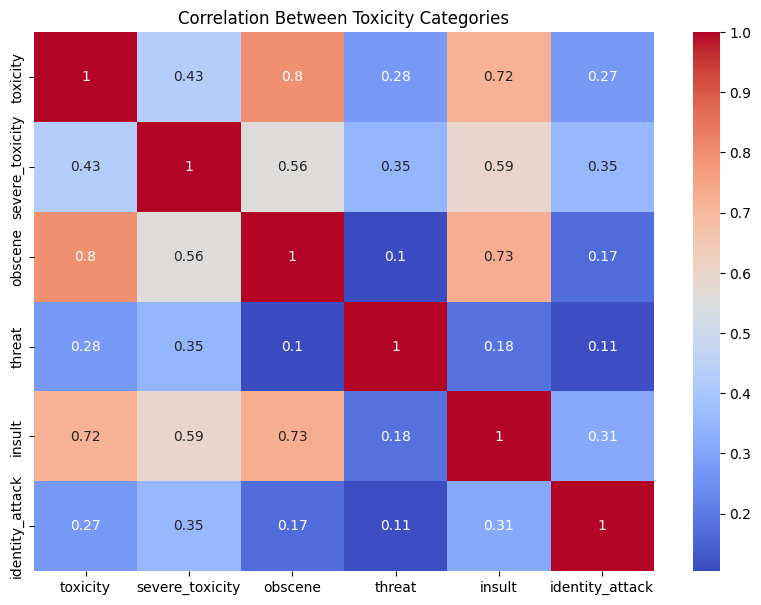

In [16]:
def plot_toxicity_correlation(df):
    toxicity_cols = [
        "toxicity", "severe_toxicity", "obscene",
        "threat", "insult", "identity_attack"
    ]
    
    plt.figure(figsize=(10,7))
    corr = df[toxicity_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Correlation Between Toxicity Categories")
    plt.show()

plot_toxicity_correlation(df)

We first created the correlation matrix of the Detoxify output scores. Overall, toxicity is strongly correlated with obscene languages and insults, indicating that toxic reviews in our dataset tend to contain these forms of language more frequently than others. In contrast, threat and identity attack scores display weak correlations with all other components, indicating that such forms of toxicity appear infrequently in the reviews. Since our study focuses specifically on overall toxicity, the remaining components scores are treated as supplementary context and are not examined further in the analysis.

## 4.2: Distribution of Toxicity Scores

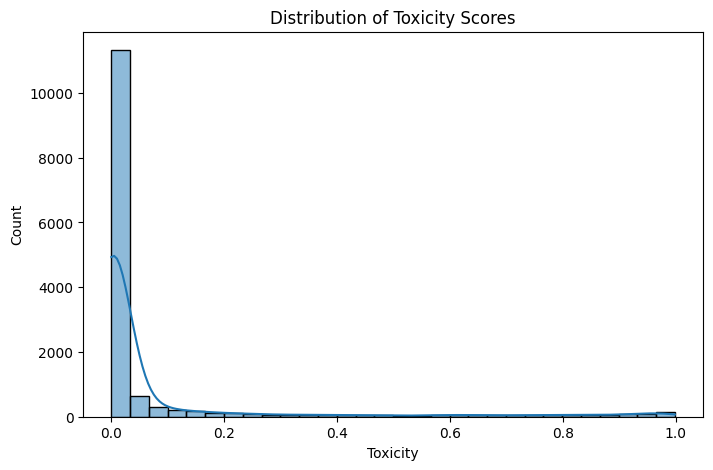

In [17]:
def plot_toxicity_distribution(df, score="toxicity"):
    plt.figure(figsize=(8,5))
    sns.histplot(df[score], kde=True, bins=30)
    plt.title(f"Distribution of {score.capitalize()} Scores")
    plt.xlabel(score.capitalize())
    plt.ylabel("Count")
    plt.show()

plot_toxicity_distribution(df)

This figure shows the overall distribution of toxicity scores across all reviews. Toxicity is highly right-skewed, with most values near zero, indicating that the majority of the reviews contain little or no toxic language. This skewed distribution justifies the use of nonparametric statical tests in subsequent analyses.

## 4.3 Toxicity vs Review Length

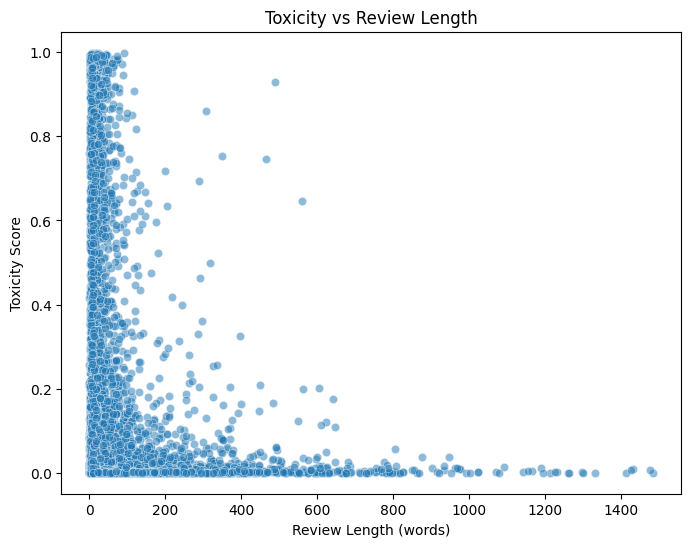

In [18]:
def plot_toxicity_vs_length(df):
    df["ReviewLength_Words"] = df["ReviewText"].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x="ReviewLength_Words",
        y="toxicity",
        data=df,
        alpha=0.5
    )
    plt.xlabel("Review Length (words)")
    plt.ylabel("Toxicity Score")
    plt.title("Toxicity vs Review Length")
    plt.show()

plot_toxicity_vs_length(df)

This plot shows the relationship between review length and toxicity. Most reviews are typically under 200 words and within this range toxicity varies considerably. However, longer reviews tend to exhibit lower toxicity scores, suggesting that highly toxic comments are more often expressed in brief, direct statements rather than extended text.

## 4.4 Toxicity vs Playtime

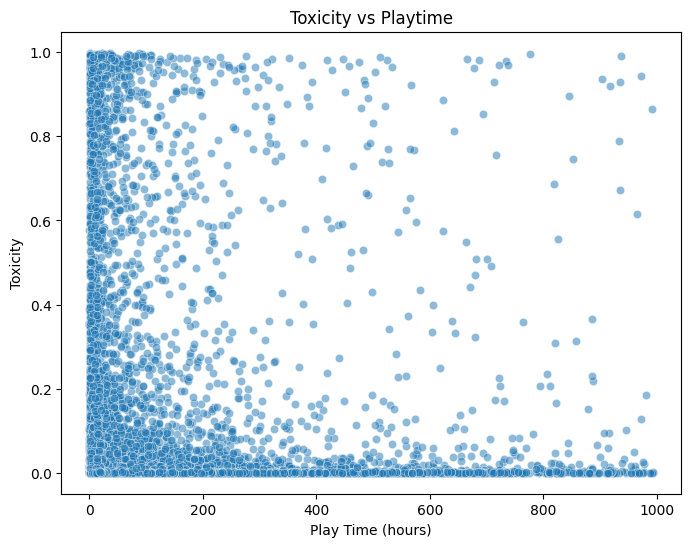

In [19]:
def plot_toxicity_vs_playtime(df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x="PlayHours_Numeric",
        y="toxicity",
        data=df,
        alpha=0.5
    )
    plt.title("Toxicity vs Playtime")
    plt.xlabel("Play Time (hours)")
    plt.ylabel("Toxicity")
    plt.show()

plot_toxicity_vs_playtime(df)

This figure shows the relationship between toxicity and the user playtime at the moment of review. The scatter pattern shows no clear trend, indicating that playtime is not a strong predictor of toxic expression.

## 4.5 Wordcloud By Toxicity

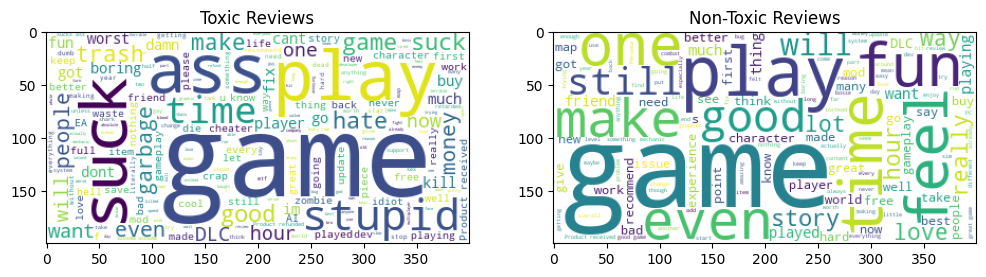

In [20]:
def wordcloud_by_toxicity(df, score="toxicity", threshold=0.5):
    toxic_text = " ".join(df[df[score] > threshold]["ReviewText"])
    nontoxic_text = " ".join(df[df[score] <= threshold]["ReviewText"])

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(WordCloud(background_color="white").generate(toxic_text))
    plt.title("Toxic Reviews")

    plt.subplot(1,2,2)
    plt.imshow(WordCloud(background_color="white").generate(nontoxic_text))
    plt.title("Non-Toxic Reviews")
    plt.show()

wordcloud_by_toxicity(df)

We classify a review as toxic when its predicted toxicity score is ≥ 0.5 (and non-toxic otherwise). Using these labels, we then generate separate word clouds correspondingly. These word clouds highlight the most frequent and distinctive terms within each group, helping us visually compare how language use differs across categories and identify recurring themes associated with toxicity.

## 4.6 Toxicity Across Game Genre (RQ1.1)

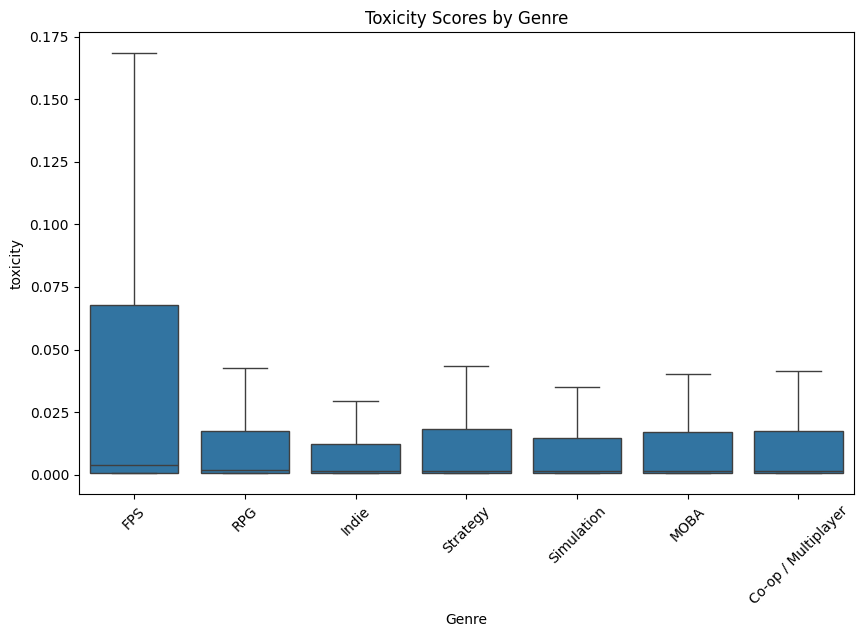

In [21]:
def plot_toxicity_by_genre(df):
    plt.figure(figsize=(10,6))
    sns.boxplot(x="Genre", y="toxicity", data=df, showfliers=False)
    plt.title("Toxicity Scores by Genre")
    plt.xticks(rotation=45)
    plt.show()

plot_toxicity_by_genre(df)

In [22]:
def describe_across_genres(df):
    print_header("Descriptive Statistics Across Game Genres")

    for genre in GENRES:
        values = df.loc[df['Genre'] == genre, 'toxicity'].dropna()
        if len(values) > 0:
            mean_val = np.mean(values)
            median_val = np.median(values)
            variance_val = np.var(values)
            print(f"Genre {genre}: n = {len(values)}, Mean = {mean_val:.4f}, Median = {median_val:.4f}, Variance = {variance_val:.4f}")
        else:
            print(f"Genre {genre}: No data available.")

def kw_across_genres(df):
    print_header("RQ1a: Toxicity Across Game Genres (Kruskal–Wallis)")

    genre_groups = []
    labels_used = []

    for genre in GENRES:
        values = df.loc[df['Genre'] == genre, 'toxicity'].dropna()
        if len(values) > 0:
            genre_groups.append(values)
            labels_used.append(genre)
            print(f"Genre {genre}: n = {len(values)}")

    if len(genre_groups) >= 2:
        H_stat, p_value = kruskal(*genre_groups)
        print(f"\nKruskal–Wallis H = {H_stat:.4f}, p = {p_value:.4e}")
    else:
        print("Not enough non-empty genre groups to run Kruskal–Wallis.")

    # Optional Dunn post-hoc test (pairwise between genres)
    if len(genre_groups) >= 2:
        print("\nDunn post-hoc test between genres (Bonferroni corrected p-values):")
        dunn_genre = sp.posthoc_dunn(
            df[['Genre', 'toxicity']],
            val_col='toxicity',
            group_col='Genre',
            p_adjust='bonferroni'
        )
        print(dunn_genre.loc[labels_used, labels_used])

describe_across_genres(df)
kw_across_genres(df)


Descriptive Statistics Across Game Genres
Genre FPS: n = 1151, Mean = 0.1291, Median = 0.0039, Variance = 0.0692
Genre RPG: n = 2275, Mean = 0.0711, Median = 0.0017, Variance = 0.0390
Genre Indie: n = 1927, Mean = 0.0619, Median = 0.0013, Variance = 0.0333
Genre Strategy: n = 2258, Mean = 0.0769, Median = 0.0015, Variance = 0.0429
Genre Simulation: n = 2083, Mean = 0.0684, Median = 0.0014, Variance = 0.0382
Genre MOBA: n = 911, Mean = 0.0648, Median = 0.0015, Variance = 0.0337
Genre Co-op / Multiplayer: n = 3635, Mean = 0.0768, Median = 0.0015, Variance = 0.0426

RQ1a: Toxicity Across Game Genres (Kruskal–Wallis)
Genre FPS: n = 1151
Genre RPG: n = 2275
Genre Indie: n = 1927
Genre Strategy: n = 2258
Genre Simulation: n = 2083
Genre MOBA: n = 911
Genre Co-op / Multiplayer: n = 3635

Kruskal–Wallis H = 68.2359, p = 9.4005e-13

Dunn post-hoc test between genres (Bonferroni corrected p-values):
                              FPS       RPG         Indie      Strategy  \
FPS                  

The figure visualises the distribution of toxicity score across different game genres (FPS, RPG, Indie, Strategy, Simulation, MOBA, Co-op). A Kruskal–Wallis test indicated a significant effect of genre on toxicity with $H = 68.23$, $p = 9.40 \times 10^{-13}$, confirming that toxicity levels differ across genres. Post-hoc Dunn comparisons show that FPS games are consistently more toxic than all other genres. RPG reviews are also slightly more toxic than Indie reviews, although this difference is comparatively small. No other pairwise differences were statistically significant, suggesting that most non-FPS genres exhibit similar toxicity patterns.

## 4.7 Toxicity Across Popularity Level (RQ1.2)

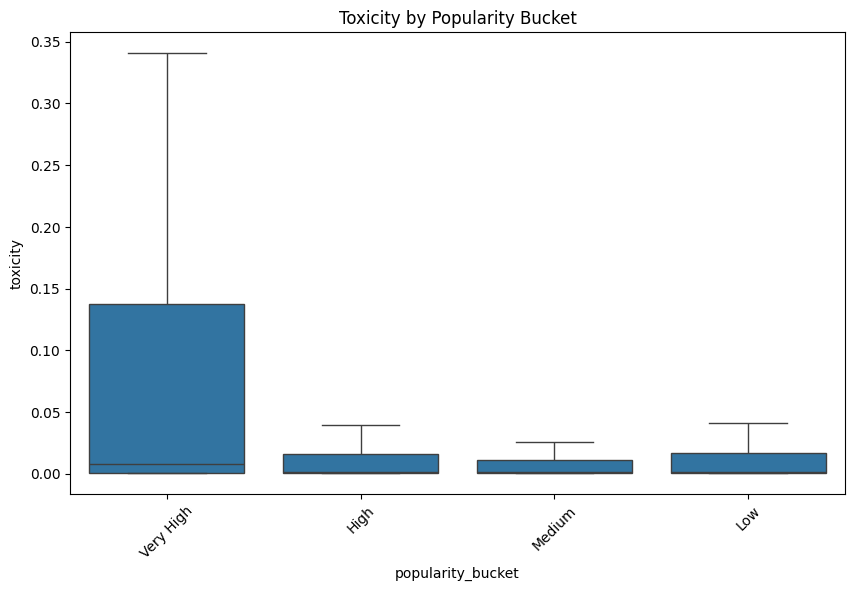

In [23]:
def plot_toxicity_by_popularity(df):
    plt.figure(figsize=(10,6))
    sns.boxplot(x="popularity_bucket", y="toxicity", data=df, order=["Very High", "High", "Medium", "Low"], showfliers=False)
    plt.title("Toxicity by Popularity Bucket")
    plt.xticks(rotation=45)
    plt.show()

plot_toxicity_by_popularity(df)

In [24]:
def describe_across_popularity(df):
    print_header("Descriptive Statistics Across Popularity Buckets")

    for b in POPULARITY_BUCKETS:
        values = df.loc[df['popularity_bucket'] == b, 'toxicity'].dropna()
        if len(values) > 0:
            mean_val = np.mean(values)
            median_val = np.median(values)
            variance_val = np.var(values)
            print(f"Bucket {b}: n = {len(values)}, Mean = {mean_val:.4f}, Median = {median_val:.4f}, Variance = {variance_val:.4f}")
        else:
            print(f"Bucket {b}: No data available.")

def kw_across_popularity(df):
    print_header("RQ1b: Toxicity Across Popularity Buckets (Kruskal–Wallis)")

    pop_groups = []
    pop_labels_used = []

    for b in POPULARITY_BUCKETS:
        values = df.loc[df['popularity_bucket'] == b, 'toxicity'].dropna()
        if len(values) > 0:
            pop_groups.append(values)
            pop_labels_used.append(b)
            print(f"Bucket {b}: n = {len(values)}")

    if len(pop_groups) >= 2:
        H_stat_pop, p_value_pop = kruskal(*pop_groups)
        print(f"\nKruskal–Wallis H = {H_stat_pop:.4f}, p = {p_value_pop:.4e}")
    else:
        print("Not enough non-empty popularity groups to run Kruskal–Wallis.")

    # Optional Dunn post-hoc test
    if len(pop_groups) >= 2:
        print("\nDunn post-hoc test between popularity buckets (Bonferroni corrected p-values):")
        dunn_pop = sp.posthoc_dunn(
            df[['popularity_bucket', 'toxicity']],
            val_col='toxicity',
            group_col='popularity_bucket',
            p_adjust='bonferroni'
        )
        print(dunn_pop.loc[pop_labels_used, pop_labels_used])

describe_across_popularity(df)
kw_across_popularity(df)


Descriptive Statistics Across Popularity Buckets
Bucket Low: n = 2880, Mean = 0.0690, Median = 0.0017, Variance = 0.0377
Bucket Medium: n = 3730, Mean = 0.0620, Median = 0.0012, Variance = 0.0342
Bucket High: n = 6331, Mean = 0.0713, Median = 0.0015, Variance = 0.0393
Bucket Very High: n = 1299, Mean = 0.1560, Median = 0.0078, Variance = 0.0801

RQ1b: Toxicity Across Popularity Buckets (Kruskal–Wallis)
Bucket Low: n = 2880
Bucket Medium: n = 3730
Bucket High: n = 6331
Bucket Very High: n = 1299

Kruskal–Wallis H = 259.4638, p = 5.8720e-56

Dunn post-hoc test between popularity buckets (Bonferroni corrected p-values):
                    Low        Medium          High     Very High
Low        1.000000e+00  4.674103e-07  3.704509e-01  4.074637e-29
Medium     4.674103e-07  1.000000e+00  5.879497e-05  2.813959e-56
High       3.704509e-01  5.879497e-05  1.000000e+00  8.653469e-43
Very High  4.074637e-29  2.813959e-56  8.653469e-43  1.000000e+00


The figure visualises the distributional differences for toxicity across popularity buckets. A Kruskal–Wallis test revealed a highly significant effect of popularity on toxicity, $H = 259.46$, $p = 5.87 \times 10^{-56}$, indicating that toxicity levels differ substantially across popularity groups. Post-hoc Dunn tests showed that games in the Very High popularity category were significantly more toxic than all other buckets. Significant differences were also observed between Low and Medium as well as between Medium and High popularity levels. No significant difference is shown between the Low and High categories. These findings suggest a clear trend in which toxicity increases with game popularity, with the Very High popularity group standing out as the most toxic.

## 4.8 Toxicity and Recommendation Status (RQ2)

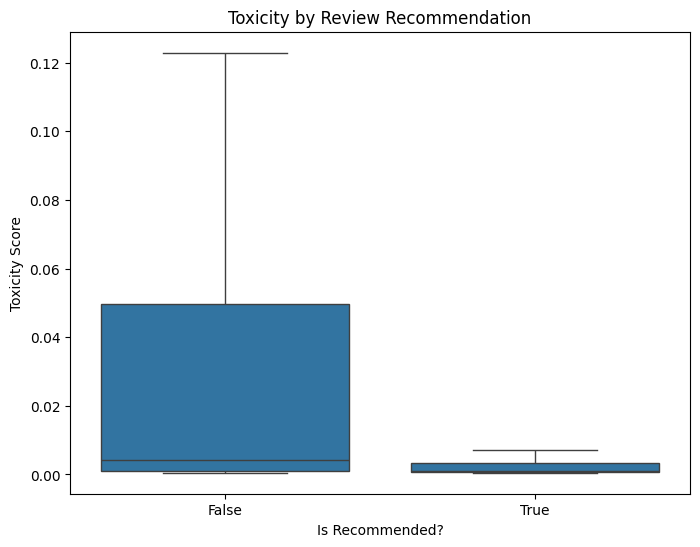

In [25]:
def plot_toxicity_by_recommendation(df):
    plt.figure(figsize=(8,6))
    sns.boxplot(
        x="IsRecommended",
        y="toxicity",
        data=df,
        showfliers=False
    )
    plt.title("Toxicity by Review Recommendation")
    plt.xlabel("Is Recommended?")
    plt.ylabel("Toxicity Score")
    plt.show()

plot_toxicity_by_recommendation(df)

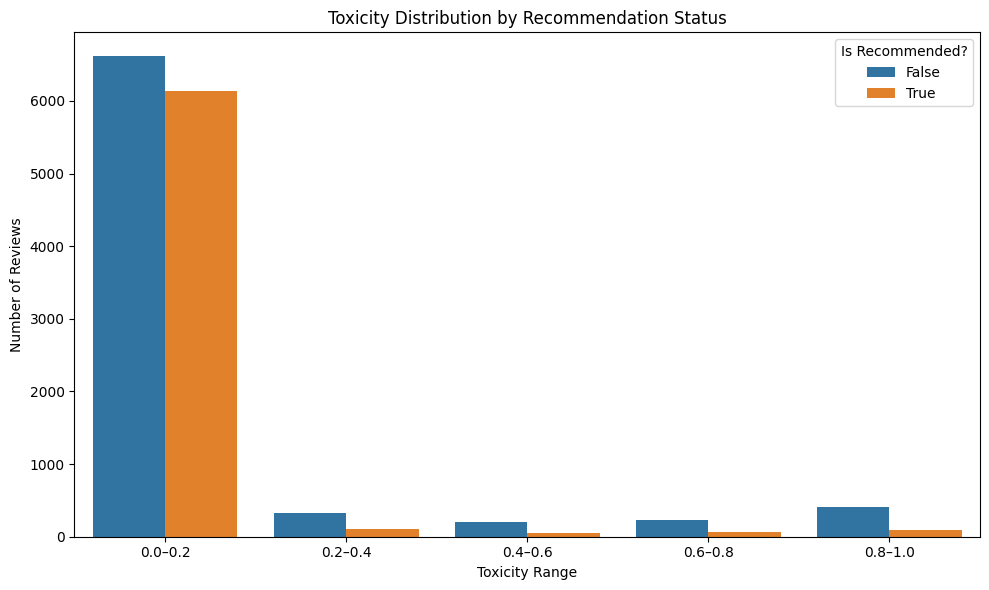

In [26]:
def plot_toxicity_binned_by_recommendation(df, bin_size=0.2):
    # Create toxicity bins
    bins = np.arange(0, 1 + bin_size, bin_size)
    labels = [f"{round(bins[i],2)}–{round(bins[i+1],2)}" for i in range(len(bins)-1)]

    df["toxicity_bin"] = pd.cut(
        df["toxicity"],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

    # Group by toxicity bin + recommendation
    toxicity_groups = (
        df.groupby(["toxicity_bin", "IsRecommended"])
          .size()
          .reset_index(name="count")
    )

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=toxicity_groups,
        x="toxicity_bin",
        y="count",
        hue="IsRecommended"
    )

    plt.title("Toxicity Distribution by Recommendation Status")
    plt.xlabel("Toxicity Range")
    plt.ylabel("Number of Reviews")
    plt.legend(title="Is Recommended?")
    plt.tight_layout()
    plt.show()

plot_toxicity_binned_by_recommendation(df)

In [27]:
def describe_recommendation(df):
    print_header("Descriptive Statistics by Recommendation Status")

    for rec_status in [True, False]:
        values = df.loc[df['IsRecommended'] == rec_status, 'toxicity'].dropna()
        if len(values) > 0:
            mean_val = np.mean(values)
            median_val = np.median(values)
            variance_val = np.var(values)
            print(f"IsRecommended = {rec_status}: n = {len(values)}, Mean = {mean_val:.4f}, Median = {median_val:.4f}, Variance = {variance_val:.4f}")
        else:
            print(f"IsRecommended = {rec_status}: No data available.")

def mw_recommended_vs_not(df):
    print_header("RQ2a: Toxicity by Recommendation Status (Mann–Whitney U)")

    rec_true = df[df['IsRecommended'] == True]['toxicity'].dropna()
    rec_false = df[df['IsRecommended'] == False]['toxicity'].dropna()

    print(f"Recommended (True): n = {len(rec_true)}")
    print(f"Not recommended (False): n = {len(rec_false)}")

    if len(rec_true) > 0 and len(rec_false) > 0:
        U_stat, p_value_u = mannwhitneyu(rec_true, rec_false, alternative='two-sided')
        print(f"\nMann–Whitney U = {U_stat:.4f}, p = {p_value_u:.4e}")

        # Optional: compute rank-biserial effect size
        n1, n2 = len(rec_true), len(rec_false)
        rank_biserial = 1 - (2 * U_stat) / (n1 * n2)
        print(f"Approx. rank-biserial effect size r_rb = {rank_biserial:.4f}")
    else:
        print("Not enough data in one or both groups for Mann–Whitney U.")

describe_recommendation(df)
mw_recommended_vs_not(df)


Descriptive Statistics by Recommendation Status
IsRecommended = True: n = 6463, Mean = 0.0365, Median = 0.0009, Variance = 0.0193
IsRecommended = False: n = 7777, Mean = 0.1090, Median = 0.0042, Variance = 0.0585

RQ2a: Toxicity by Recommendation Status (Mann–Whitney U)
Recommended (True): n = 6463
Not recommended (False): n = 7777

Mann–Whitney U = 15362152.0000, p = 0.0000e+00
Approx. rank-biserial effect size r_rb = 0.3887


The above figures compare toxicity levels between recommended and not-recommended reviews. Visual inspection indicates that not-recommended reviews tend to have higher median toxicity. This observation is supported by a Mann–Whitney U test, which revealed a significant difference between the two groups ($n_{\text{rec}} = 6{,}463$, $n_{\text{not-rec}} = 7{,}777$, $U = 15{,}362{,}152$, $p < .001$). The rank-biserial effect size ($r_{\mathrm{rb}} = 0.389$) suggests a moderate-to-large practical difference, with not-recommended reviews exhibiting higher toxicity. These findings support the hypothesis that negative evaluations on Steam are more likely to contain toxic language.